In [1]:
!pip install statsmodels scikit-learn matplotlib seaborn --break-system-packages
%load_ext autoreload
%autoreload 2


## Model 

#### Return_it = α_i + δ_t + β(Post_t × HighTPU_i) + γ₁COVID_t + γ₂X_it + ε_it


In [2]:
""" 

α_i: 公司固定效果（使用product作為公司識別）
δ_t: 時間固定效果（年份+季度）
Post_t × HighTPU_i: DID交互項（核心解釋變數）
COVID_t: 疫情控制變數
X_it: 控制變數（市值權重、P/B比、周轉率、交易筆數）

""" 

' \n\nα_i: 公司固定效果（使用product作為公司識別）\nδ_t: 時間固定效果（年份+季度）\nPost_t × HighTPU_i: DID交互項（核心解釋變數）\nCOVID_t: 疫情控制變數\nX_it: 控制變數（市值權重、P/B比、周轉率、交易筆數）\n\n'

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [8]:
path= '/Volumes/T7/code/學校課程/econometrics/group/data/agg_df.csv'
df = pd.read_csv(path)
df['date'] = pd.to_datetime(df['date'])

In [9]:
df['company_code'].unique()

array([5347, 3443, 6269, 8215, 3131, 1201, 1203, 3034, 6153, 1210, 2454,
       1216, 1219, 2338, 1227, 1229, 2313, 1215, 1231, 3661, 2385, 2882,
       2884, 2885, 2881, 2886, 2887, 2880, 3376, 2891, 8016, 2301, 2329,
       6239, 2357, 2382, 3707, 5871, 1702, 2883])

In [10]:
gp  =df.groupby('company_code')
s = gp.get_group(2338)

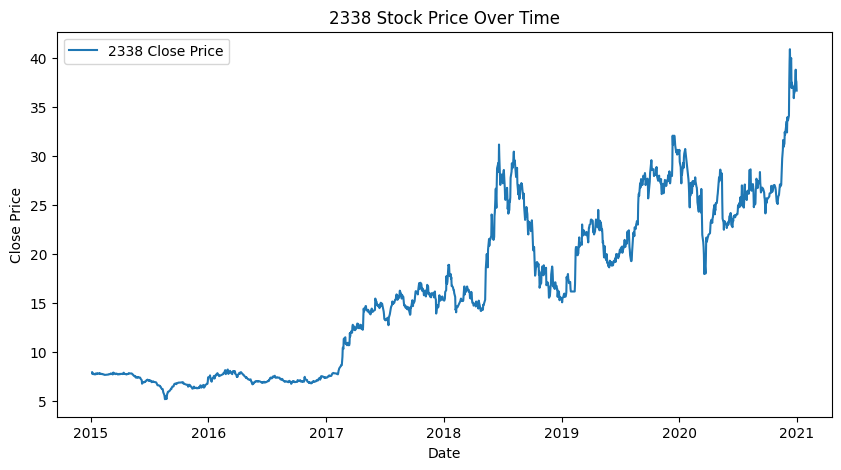

In [11]:
x = s['date']
plt.figure(figsize=(10, 5))
plt.plot(x, s['close'], label='2338 Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('2338 Stock Price Over Time')
plt.legend()
plt.show()

In [12]:
df['industry'].unique()

array(['電子', '半導', '食品', '金保'], dtype=object)

In [48]:
# import pandas as pd
# import numpy as np
# import statsmodels.formula.api as smf
# import matplotlib.pyplot as plt
# import seaborn as sns

# def create_tpu_risk_premium_model(df):
#     """
#     建立貿易政策不確定性與風險溢酬DID模型
    
#     研究假設: 高TPU敏感度產業在中美貿易戰期間，因風險溢酬上升導致股價表現更差
#     預期: β < 0 (DID係數為負)
    
#     Return_it = α_i + δ_t + β(Post_t × HighTPU_i) + γ₁COVID_t + γ₂X_it + ε_it
#     """
#     # 複製資料
#     model_df = df.copy()
    
#     # 確保日期格式
#     model_df['date'] = pd.to_datetime(model_df['date'])
#     model_df['year'] = model_df['date'].dt.year
#     model_df['quarter'] = model_df['date'].dt.quarter
    
#     # 定義中美貿易戰時期 (2018年川普正式加徵關稅)
#     model_df['Post'] = (model_df['year'] >= 2018).astype(int)
    
#     # 定義高TPU敏感度產業 (基於貿易政策敏感度)
#     # 高TPU組: 半導體、電子 (出口導向、製造業、供應鏈全球化)
#     # 控制組: 食品、金保 (內需導向、服務業、較少直接貿易衝擊)
#     high_tpu_industries = ['半導', '電子']
#     model_df['HighTPU'] = model_df['industry'].isin(high_tpu_industries).astype(int)
    
#     # DID交互項 (核心解釋變數)
#     model_df['Post_x_HighTPU'] = model_df['Post'] * model_df['HighTPU']
    
#     # COVID控制變數 (2020-2022疫情期間)
#     model_df['COVID'] = ((model_df['year'] >= 2020) & (model_df['year'] <= 2022)).astype(int)
    
#     # 時間固定效果
#     model_df['time_fe'] = model_df['year'].astype(str) + '_Q' + model_df['quarter'].astype(str)
    
#     # 輸出基本統計
#     print("="*60)
#     print("貿易政策不確定性與風險溢酬分析")
#     print("="*60)
#     print(f"資料期間: {model_df['year'].min()} - {model_df['year'].max()}")
#     print(f"總公司數: {model_df['company_code'].nunique()}")
#     print(f"總觀察值: {len(model_df)}")
    
#     print(f"\n產業分組:")
#     print(f"高TPU敏感度產業: {high_tpu_industries}")
#     print(f"- 公司數: {model_df[model_df['HighTPU']==1]['company_code'].nunique()}")
#     print(f"- 觀察值: {len(model_df[model_df['HighTPU']==1])}")
    
#     control_industries = model_df[model_df['HighTPU']==0]['industry'].unique().tolist()
#     print(f"控制組產業: {control_industries}")
#     print(f"- 公司數: {model_df[model_df['HighTPU']==0]['company_code'].nunique()}")
#     print(f"- 觀察值: {len(model_df[model_df['HighTPU']==0])}")
    
#     print(f"\n時間分組:")
#     print(f"貿易戰前期間 (Pre-2018): {len(model_df[model_df['Post']==0])} 觀察值")
#     print(f"貿易戰期間 (2018+): {len(model_df[model_df['Post']==1])} 觀察值")
    
#     return model_df

# def estimate_did_model(model_df):
#     """
#     估計DID模型 - 檢驗TPU風險溢酬假說
#     """
#     # 移除缺失值
#     required_vars = ['return', 'market_weight', 'pb_ratio', 'turnover_rate', 'trade_count']
#     analysis_df = model_df.dropna(subset=required_vars).copy()
    
#     # 重新命名return欄位 (避免Python關鍵字衝突)
#     analysis_df = analysis_df.rename(columns={'return': 'stock_return'})
    
#     print(f"\n模型估計樣本: {len(analysis_df)} 觀察值")
    
#     # DID回歸模型 (包含公司和時間固定效果)
#     formula = """
#     stock_return ~ Post_x_HighTPU + COVID + market_weight + pb_ratio + 
#                    turnover_rate + trade_count + C(company_code) + C(time_fe)
#     """
    
#     try:
#         # 估計固定效果模型
#         model = smf.ols(formula, data=analysis_df)
#         results = model.fit()
        
#         print("\n" + "="*70)
#         print("DID回歸結果 - 貿易政策不確定性與風險溢酬")
#         print("="*70)
        
#         # 提取關鍵係數
#         did_coef = results.params.get('Post_x_HighTPU', np.nan)
#         did_pvalue = results.pvalues.get('Post_x_HighTPU', np.nan)
#         did_se = results.bse.get('Post_x_HighTPU', np.nan)
#         covid_coef = results.params.get('COVID', np.nan)
        
#         # 統計顯著性
#         stars = ''
#         if did_pvalue < 0.01:
#             stars = '***'
#         elif did_pvalue < 0.05:
#             stars = '**'
#         elif did_pvalue < 0.1:
#             stars = '*'
        
#         print(f"DID係數 (β): {did_coef:.6f}{stars}")
#         print(f"標準誤: {did_se:.6f}")
#         print(f"t統計量: {did_coef/did_se:.3f}")
#         print(f"p值: {did_pvalue:.4f}")
#         print(f"COVID控制: {covid_coef:.6f}")
#         print(f"R-squared: {results.rsquared:.4f}")
#         print(f"調整後R-squared: {results.rsquared_adj:.4f}")
        
#         print(f"\n*** 研究發現 ***")
        
#         # 假說檢驗結果
#         if did_coef < 0 and did_pvalue < 0.05:
#             print(f"✓ 支持TPU風險溢酬假說")
#             print(f"  高TPU產業在貿易戰期間相對表現更差 {did_coef:.2%}")
#             print(f"  證據：風險溢酬上升導致股價下跌")
#         elif did_coef > 0 and did_pvalue < 0.05:
#             print(f"✗ 不支持TPU風險溢酬假說")
#             print(f"  高TPU產業在貿易戰期間相對表現更好 {did_coef:.2%}")
#             print(f"  可能存在「替代性利多」效應 (簡士強, 2020)")
#         else:
#             print(f"? TPU效應不顯著")
#             print(f"  無法確認風險溢酬機制的存在")
        
#         # 經濟意義解釋
#         if abs(did_coef) > 0.001 and did_pvalue < 0.1:
#             effect_size = "大" if abs(did_coef) > 0.02 else "中等" if abs(did_coef) > 0.01 else "小"
#             print(f"\n經濟意義: 效果大小為 {effect_size} ({abs(did_coef):.2%})")
        
#         print(f"\n完整回歸結果:")
#         print(results.summary())
        
#         return results, analysis_df
        
#     except Exception as e:
#         print(f"模型估計錯誤: {e}")
#         print("嘗試簡化模型...")
        
#         # 簡化模型：移除固定效果
#         simple_formula = """
#         stock_return ~ Post_x_HighTPU + HighTPU + Post + COVID + 
#                        market_weight + pb_ratio + turnover_rate + trade_count
#         """
        
#         try:
#             simple_model = smf.ols(simple_formula, data=analysis_df)
#             simple_results = simple_model.fit()
            
#             print("使用簡化模型 (無固定效果):")
#             did_coef = simple_results.params.get('Post_x_HighTPU', np.nan)
#             did_pvalue = simple_results.pvalues.get('Post_x_HighTPU', np.nan)
            
#             print(f"DID係數: {did_coef:.6f}")
#             print(f"p值: {did_pvalue:.4f}")
#             print(simple_results.summary())
            
#             return simple_results, analysis_df
            
#         except Exception as e2:
#             print(f"簡化模型也失敗: {e2}")
#             return None, None

# def create_diagnostic_plots(analysis_df):
#     """
#     創建DID診斷圖表
#     """
#     fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
#     # 設定中文字體
#     plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei']
#     plt.rcParams['axes.unicode_minus'] = False
    
#     # 1. 平行趨勢檢驗
#     trend_data = analysis_df.groupby(['year', 'HighTPU'])['stock_return'].mean().reset_index()
    
#     colors = ['#2E86AB', '#A23B72']  # 藍色和紫色
#     for i, group in enumerate([0, 1]):
#         group_data = trend_data[trend_data['HighTPU'] == group]
#         label = '高TPU產業 (半導+電子)' if group == 1 else '控制組 (食品+金保)'
#         axes[0, 0].plot(group_data['year'], group_data['stock_return'], 
#                        marker='o', linewidth=3, markersize=8, 
#                        color=colors[i], label=label)
    
#     axes[0, 0].axvline(x=2018, color='red', linestyle='--', linewidth=2, alpha=0.8, label='貿易戰開始')
#     axes[0, 0].axvline(x=2020, color='orange', linestyle='--', linewidth=2, alpha=0.8, label='COVID開始')
#     axes[0, 0].set_title('平行趨勢檢驗\n(TPU風險溢酬假說)', fontsize=14, fontweight='bold')
#     axes[0, 0].set_xlabel('年份')
#     axes[0, 0].set_ylabel('平均股票報酬率 (%)')
#     axes[0, 0].legend(loc='best')
#     axes[0, 0].grid(True, alpha=0.3)
    
#     # 2. DID效果分解表
#     did_table = analysis_df.groupby(['Post', 'HighTPU'])['stock_return'].mean().unstack()
    
#     if did_table.shape == (2, 2):
#         # 手動計算DID效果
#         pre_diff = did_table.loc[0, 1] - did_table.loc[0, 0]  # 貿易戰前差異
#         post_diff = did_table.loc[1, 1] - did_table.loc[1, 0]  # 貿易戰後差異
#         did_effect = post_diff - pre_diff  # DID效果
        
#         axes[0, 1].axis('tight')
#         axes[0, 1].axis('off')
        
#         table_data = [
#             ['期間', '控制組', '高TPU組', '組間差異'],
#             ['貿易戰前', f'{did_table.loc[0, 0]:.3f}', f'{did_table.loc[0, 1]:.3f}', f'{pre_diff:.3f}'],
#             ['貿易戰後', f'{did_table.loc[1, 0]:.3f}', f'{did_table.loc[1, 1]:.3f}', f'{post_diff:.3f}'],
#             ['時間差異', f'{did_table.loc[1, 0] - did_table.loc[0, 0]:.3f}', 
#              f'{did_table.loc[1, 1] - did_table.loc[0, 1]:.3f}', f'{did_effect:.3f}']
#         ]
        
#         table = axes[0, 1].table(cellText=table_data, cellLoc='center', loc='center')
#         table.auto_set_font_size(False)
#         table.set_fontsize(11)
#         table.scale(1, 2.5)
        
#         # 突出顯示DID效果
#         table[(3, 3)].set_facecolor('#FFE5E5' if did_effect < 0 else '#E5FFE5')
#         table[(3, 3)].set_text_props(weight='bold')
        
#         axes[0, 1].set_title(f'DID效果分解\nDID係數: {did_effect:.3f}', fontsize=14, fontweight='bold')
    
#     # 3. 產業報酬率分布
#     high_tpu_returns = analysis_df[analysis_df['HighTPU'] == 1]['stock_return']
#     control_returns = analysis_df[analysis_df['HighTPU'] == 0]['stock_return']
    
#     axes[1, 0].hist(control_returns, bins=50, alpha=0.6, label='控制組', 
#                    color='#2E86AB', density=True, edgecolor='white')
#     axes[1, 0].hist(high_tpu_returns, bins=50, alpha=0.6, label='高TPU組', 
#                    color='#A23B72', density=True, edgecolor='white')
    
#     # 添加平均線
#     axes[1, 0].axvline(control_returns.mean(), color='#2E86AB', linestyle='-', linewidth=2, alpha=0.8)
#     axes[1, 0].axvline(high_tpu_returns.mean(), color='#A23B72', linestyle='-', linewidth=2, alpha=0.8)
    
#     axes[1, 0].set_title('股票報酬率分布比較', fontsize=14, fontweight='bold')
#     axes[1, 0].set_xlabel('股票報酬率 (%)')
#     axes[1, 0].set_ylabel('密度')
#     axes[1, 0].legend()
    
#     # 4. 貿易戰前後比較
#     pre_war = analysis_df[analysis_df['Post'] == 0].groupby('HighTPU')['stock_return'].mean()
#     post_war = analysis_df[analysis_df['Post'] == 1].groupby('HighTPU')['stock_return'].mean()
    
#     x = np.arange(2)
#     width = 0.35
    
#     bars1 = axes[1, 1].bar(x - width/2, pre_war.values, width, label='貿易戰前', 
#                           color='lightblue', alpha=0.8, edgecolor='black')
#     bars2 = axes[1, 1].bar(x + width/2, post_war.values, width, label='貿易戰後', 
#                           color='lightcoral', alpha=0.8, edgecolor='black')
    
#     axes[1, 1].set_title('貿易戰前後報酬率比較', fontsize=14, fontweight='bold')
#     axes[1, 1].set_xlabel('產業組別')
#     axes[1, 1].set_ylabel('平均報酬率 (%)')
#     axes[1, 1].set_xticks(x)
#     axes[1, 1].set_xticklabels(['控制組', '高TPU組'])
#     axes[1, 1].legend()
    
#     # 在柱狀圖上顯示數值
#     for bars in [bars1, bars2]:
#         for bar in bars:
#             height = bar.get_height()
#             axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
#                            f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
    
#     plt.tight_layout()
#     plt.show()
    
#     # 輸出詳細統計
#     print("\n" + "="*50)
#     print("描述性統計")
#     print("="*50)
    
#     for group, name in [(0, '控制組'), (1, '高TPU組')]:
#         group_data = analysis_df[analysis_df['HighTPU'] == group]
#         pre_data = group_data[group_data['Post'] == 0]['stock_return']
#         post_data = group_data[group_data['Post'] == 1]['stock_return']
        
#         print(f"\n{name}:")
#         print(f"  貿易戰前平均報酬: {pre_data.mean():.4f} (標準差: {pre_data.std():.4f})")
#         print(f"  貿易戰後平均報酬: {post_data.mean():.4f} (標準差: {post_data.std():.4f})")
#         print(f"  時間差異: {post_data.mean() - pre_data.mean():.4f}")



In [50]:
# model_df = create_tpu_risk_premium_model(df)

In [51]:
# results, analysis_df = estimate_did_model(model_df)

In [47]:
# create_diagnostic_plots(analysis_df)

### Prove by more indicator

In [36]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# =================== 步驟1：建立基礎模型 ===================

def create_tpu_risk_premium_model(df):
    """
    建立貿易政策不確定性與風險溢酬DID模型
    
    研究假設: 高TPU敏感度產業在中美貿易戰期間，因風險溢酬上升導致股價表現更差
    預期: β < 0 (DID係數為負)
    
    Return_it = α_i + δ_t + β(Post_t × HighTPU_i) + γ₁COVID_t + γ₂X_it + ε_it
    """
    # 複製資料
    model_df = df.copy()
    
    # 確保日期格式
    model_df['date'] = pd.to_datetime(model_df['date'])
    model_df['year'] = model_df['date'].dt.year
    model_df['quarter'] = model_df['date'].dt.quarter
    
    # 定義中美貿易戰時期 (2018年川普正式加徵關稅)
    model_df['Post'] = (model_df['year'] >= 2018).astype(int)
    
    # 定義高TPU敏感度產業 (基於貿易政策敏感度)
    # 高TPU組: 半導體、電子 (出口導向、製造業、供應鏈全球化)
    # 控制組: 食品、金保 (內需導向、服務業、較少直接貿易衝擊)
    high_tpu_industries = ['半導', '電子']
    model_df['HighTPU'] = model_df['industry'].isin(high_tpu_industries).astype(int)
    
    # DID交互項 (核心解釋變數)
    model_df['Post_x_HighTPU'] = model_df['Post'] * model_df['HighTPU']
    
    # COVID控制變數 (2020-2022疫情期間)
    model_df['COVID'] = ((model_df['year'] >= 2020) & (model_df['year'] <= 2022)).astype(int)
    
    # 時間固定效果
    model_df['time_fe'] = model_df['year'].astype(str) + '_Q' + model_df['quarter'].astype(str)
    
    # 輸出基本統計
    print("="*60)
    print("貿易政策不確定性與風險溢酬分析")
    print("="*60)
    print(f"資料期間: {model_df['year'].min()} - {model_df['year'].max()}")
    print(f"總公司數: {model_df['company_code'].nunique()}")
    print(f"總觀察值: {len(model_df)}")
    
    print(f"\n產業分組:")
    print(f"高TPU敏感度產業: {high_tpu_industries}")
    print(f"- 公司數: {model_df[model_df['HighTPU']==1]['company_code'].nunique()}")
    print(f"- 觀察值: {len(model_df[model_df['HighTPU']==1])}")
    
    control_industries = model_df[model_df['HighTPU']==0]['industry'].unique().tolist()
    print(f"控制組產業: {control_industries}")
    print(f"- 公司數: {model_df[model_df['HighTPU']==0]['company_code'].nunique()}")
    print(f"- 觀察值: {len(model_df[model_df['HighTPU']==0])}")
    
    print(f"\n時間分組:")
    print(f"貿易戰前期間 (Pre-2018): {len(model_df[model_df['Post']==0])} 觀察值")
    print(f"貿易戰期間 (2018+): {len(model_df[model_df['Post']==1])} 觀察值")
    
    return model_df

# =================== 步驟2：計算改進版風險指標 ===================

def calculate_improved_volatility_measures(df, company_col='company_code', return_col='stock_return', date_col='date'):
    """
    計算更具經濟意涵的波動性指標
    """
    print("📈 計算改進版波動性指標...")
    print("="*50)
    
    model_df = df.copy()
    
    # 確保數據按公司和日期排序
    model_df = model_df.sort_values([company_col, date_col])
    
    # 1. 特異風險 (Idiosyncratic Risk) - 最重要的改進
    print("1. 計算特異風險（去除市場因子）...")
    
    # 計算市場報酬（等權重或市值加權）
    if 'market_weight' in model_df.columns:
        # 市值加權市場報酬 - 修正版
        daily_market_return = []
        for date in model_df[date_col].unique():
            date_data = model_df[model_df[date_col] == date]
            if len(date_data) > 0:
                weighted_return = (date_data[return_col] * date_data['market_weight']).sum() / date_data['market_weight'].sum()
                daily_market_return.append({date_col: date, 'market_return': weighted_return})
        daily_market_return = pd.DataFrame(daily_market_return)
    else:
        # 等權重市場報酬
        daily_market_return = model_df.groupby(date_col)[return_col].mean().reset_index()
        daily_market_return.columns = [date_col, 'market_return']
    
    # 合併市場報酬
    model_df = model_df.merge(daily_market_return, on=date_col, how='left')
    
    # 計算超額報酬
    model_df['excess_return'] = model_df[return_col] - model_df['market_return']
    
    # 特異風險 = 超額報酬的滾動標準差
    model_df['idiosyncratic_risk'] = model_df.groupby(company_col)['excess_return'].transform(
        lambda x: x.rolling(window=20, min_periods=10).std()  # 用20個交易日
    )
    
    # 2. 下檔風險 (Downside Risk)
    print("2. 計算下檔風險...")
    
    def calculate_downside_risk(returns, threshold=0, window=20):
        """計算下檔風險（低於閾值的波動性）"""
        def downside_std(x):
            downside_returns = x[x < threshold]
            if len(downside_returns) < 3:
                return np.nan
            return downside_returns.std()
        
        return returns.rolling(window=window, min_periods=10).apply(downside_std)
    
    model_df['downside_risk'] = model_df.groupby(company_col)[return_col].transform(
        lambda x: calculate_downside_risk(x)
    )
    
    # 3. 實現波動性 (Realized Volatility)
    print("3. 計算實現波動性...")
    
    model_df['realized_volatility'] = model_df.groupby(company_col)[return_col].transform(
        lambda x: x.rolling(window=20, min_periods=10).apply(
            lambda returns: np.sqrt(np.sum(returns**2) * 250)  # 年化
        )
    )
    
    # 4. VaR風險 (Value at Risk)
    print("4. 計算VaR風險...")
    
    def calculate_var(returns, confidence=0.05, window=60):
        """計算VaR（95%信心水準）"""
        return returns.rolling(window=window, min_periods=30).quantile(confidence)
    
    model_df['var_5pct'] = model_df.groupby(company_col)[return_col].transform(
        lambda x: calculate_var(x)
    )
    
    # VaR風險指標（取絕對值，越大越危險）
    model_df['var_risk'] = abs(model_df['var_5pct'])
    
    # 5. 條件風險 (Conditional Risk)
    print("5. 計算條件風險...")
    
    def calculate_cvar(returns, confidence=0.05, window=60):
        """計算CVaR（條件風險價值）"""
        def cvar_func(x):
            if len(x) < 30:
                return np.nan
            var_threshold = x.quantile(confidence)
            tail_returns = x[x <= var_threshold]
            return tail_returns.mean() if len(tail_returns) > 0 else np.nan
        
        return returns.rolling(window=window, min_periods=30).apply(cvar_func)
    
    model_df['cvar_5pct'] = model_df.groupby(company_col)[return_col].transform(
        lambda x: calculate_cvar(x)
    )
    
    # CVaR風險指標
    model_df['cvar_risk'] = abs(model_df['cvar_5pct'])
    
    print("✅ 波動性指標計算完成")
    
    return model_df

def calculate_improved_liquidity_risk(df, company_col='company_code', date_col='date'):
    """
    重新設計流動性風險指標
    """
    print("\n💧 重新設計流動性風險指標...")
    print("="*50)
    
    model_df = df.copy()
    
    # 1. Amihud非流動性比率
    print("1. 計算Amihud非流動性比率...")
    
    model_df['amihud_illiquidity'] = (
        abs(model_df['stock_return']) / 
        (model_df['turnover_rate'] * model_df.get('market_weight', 1) + 1e-8)
    )
    
    # 標準化（按日期橫斷面）
    model_df['amihud_illiquidity_std'] = model_df.groupby(date_col)['amihud_illiquidity'].transform(
        lambda x: (x - x.mean()) / (x.std() + 1e-8)
    )
    
    # 2. 價格衝擊指標
    print("2. 計算價格衝擊指標...")
    
    model_df['price_impact'] = (
        model_df['realized_volatility'] / 
        (model_df['turnover_rate'] + 1e-8)
    )
    
    # 標準化
    model_df['price_impact_std'] = model_df.groupby(date_col)['price_impact'].transform(
        lambda x: (x - x.mean()) / (x.std() + 1e-8)
    )
    
    # 3. Roll買賣價差估計
    print("3. 計算買賣價差代理...")
    
    def calculate_roll_spread(returns, window=20):
        """計算Roll買賣價差估計"""
        def roll_estimator(x):
            if len(x) < 10:
                return np.nan
            autocorr = x.autocorr(lag=1)
            if pd.isna(autocorr) or autocorr >= 0:
                return 0
            return 2 * np.sqrt(-autocorr)
        
        return returns.rolling(window=window, min_periods=10).apply(roll_estimator)
    
    model_df['roll_spread'] = model_df.groupby(company_col)['stock_return'].transform(
        lambda x: calculate_roll_spread(x)
    )
    
    # 4. 零交易日比例
    print("4. 計算零交易日比例...")
    
    def zero_trading_ratio(turnover, threshold_pct=5, window=30):
        """計算低交易量日數比例"""
        def zero_ratio(x):
            if len(x) < 10:
                return np.nan
            threshold = np.percentile(x.dropna(), threshold_pct)
            zero_days = (x <= threshold).sum()
            return zero_days / len(x)
        
        return turnover.rolling(window=window, min_periods=10).apply(zero_ratio)
    
    model_df['zero_trading_ratio'] = model_df.groupby(company_col)['turnover_rate'].transform(
        lambda x: zero_trading_ratio(x)
    )
    
    # 5. 綜合流動性風險指標
    print("5. 建構綜合流動性風險指標...")
    
    liquidity_components = ['amihud_illiquidity_std', 'price_impact_std', 'roll_spread', 'zero_trading_ratio']
    
    for component in liquidity_components:
        if component in model_df.columns:
            model_df[f'{component}_normalized'] = model_df.groupby(date_col)[component].transform(
                lambda x: (x - x.mean()) / (x.std() + 1e-8)
            )
    
    # 綜合流動性風險指標（等權重）
    normalized_components = [f'{comp}_normalized' for comp in liquidity_components 
                           if f'{comp}_normalized' in model_df.columns]
    
    if normalized_components:
        model_df['liquidity_risk_composite'] = model_df[normalized_components].mean(axis=1, skipna=True)
    
    print("✅ 流動性風險指標計算完成")
    
    return model_df

def calculate_comprehensive_risk_premium_proxies(df):
    """
    整合改進版風險溢酬代理變數
    """
    print("🚀 開始計算綜合改進版風險溢酬指標...")
    print("="*70)
    
    # 處理欄位名稱
    model_df = df.copy()
    if 'return' in model_df.columns and 'stock_return' not in model_df.columns:
        model_df = model_df.rename(columns={'return': 'stock_return'})
        print("✅ 已將 'return' 重新命名為 'stock_return'")
    
    # 1. 改進版波動性指標
    model_df = calculate_improved_volatility_measures(model_df)
    
    # 2. 改進版流動性風險指標
    model_df = calculate_improved_liquidity_risk(model_df)
    
    # 3. 估值分散度
    print("\n📊 計算估值風險指標...")
    model_df['valuation_dispersion'] = model_df.groupby('date')['pb_ratio'].transform(
        lambda x: abs(x - x.median()) / (x.median() + 1e-8)
    )
    
    # 4. 建立新的綜合風險溢酬指標
    print("\n🎯 建構新的綜合風險溢酬指標...")
    
    # 選擇最佳風險代理指標
    primary_risk_indicators = {
        'systematic_risk': 'idiosyncratic_risk',      # 特異風險（最重要）
        'tail_risk': 'cvar_risk',                     # 尾部風險
        'liquidity_risk': 'liquidity_risk_composite', # 綜合流動性風險
        'valuation_risk': 'valuation_dispersion'      # 估值風險
    }
    
    # 標準化各指標
    for risk_name, indicator in primary_risk_indicators.items():
        if indicator in model_df.columns:
            model_df[f'{risk_name}_std'] = model_df.groupby('date')[indicator].transform(
                lambda x: (x - x.mean()) / (x.std() + 1e-8)
            )
    
    # 新的綜合風險溢酬指標（理論加權）
    weights = {
        'systematic_risk_std': 0.4,    # 特異風險最重要
        'tail_risk_std': 0.3,          # 尾部風險次之
        'liquidity_risk_std': 0.2,     # 流動性風險
        'valuation_risk_std': 0.1      # 估值風險
    }
    
    available_indicators = [indicator for indicator in weights.keys() if indicator in model_df.columns]
    
    if available_indicators:
        # 標準化權重
        total_weight = sum(weights[ind] for ind in available_indicators)
        normalized_weights = {ind: weights[ind]/total_weight for ind in available_indicators}
        
        model_df['risk_premium_index_v2'] = sum(
            normalized_weights[ind] * model_df[ind] 
            for ind in available_indicators
        )
        
        print(f"✅ 新綜合指標權重: {normalized_weights}")
    
    # 5. 風險調整後報酬（多種版本）
    print("\n📈 計算多種風險調整後報酬...")
    
    # 版本1：特異風險調整
    model_df['risk_adjusted_return_v1'] = (
        model_df['stock_return'] / (model_df['idiosyncratic_risk'] + 0.001)
    )
    
    # 版本2：下檔風險調整
    model_df['risk_adjusted_return_v2'] = (
        model_df['stock_return'] / (model_df['downside_risk'] + 0.001)
    )
    
    # 版本3：VaR風險調整
    model_df['risk_adjusted_return_v3'] = (
        model_df['stock_return'] / (model_df['var_risk'] + 0.001)
    )
    
    print("="*70)
    print("✅ 綜合風險溢酬指標計算完成!")
    
    return model_df

# =================== 步驟3：平行趨勢檢驗 ===================

def parallel_trends_test(model_df):
    """
    平行趨勢檢驗改進版（處理數據不足問題）
    """
    print(f"\n" + "="*60)
    print("平行趨勢檢驗")
    print("="*60)
    
    # 確保有足夠的事前期間
    model_df['year'] = pd.to_datetime(model_df['date']).dt.year
    pre_treatment_years = sorted(model_df[model_df['year'] < 2018]['year'].unique())
    
    print(f"可用事前年份：{pre_treatment_years}")
    
    if len(pre_treatment_years) < 2:
        print("❌ 事前期間嚴重不足（少於2年）")
        print("   建議：")
        print("   1. 擴展資料期間至2015-2016年")
        print("   2. 使用替代研究設計（如事件研究法）")
        print("   3. 進行簡單的描述性比較")
        
        # 進行簡單的組間比較
        print(f"\n📊 簡單描述性比較：")
        simple_comparison(model_df)
        return None
    
    elif len(pre_treatment_years) < 3:
        print("⚠️  事前期間有限，平行趨勢檢驗說服力較弱")
        print(f"   建議增加更多事前年份數據")
    
    # 建立事前趨勢交互項
    test_df = model_df.copy()
    
    # 以最後一年為基期，建立其他年份交互項
    if len(pre_treatment_years) >= 2:
        base_year = pre_treatment_years[-1]  # 最後一年作為基期
        trend_years = pre_treatment_years[:-1]  # 其他年份
        
        for year in trend_years:
            test_df[f'HighTPU_x_{year}'] = (
                test_df['HighTPU'] * (test_df['year'] == year).astype(int)
            )
        
        # 建立平行趨勢檢驗公式
        trend_vars = [f'HighTPU_x_{year}' for year in trend_years]
        
        if len(trend_vars) > 0:  # 確保有交互項
            trend_formula = ' + '.join(trend_vars)
            
            formula = f"""
            stock_return ~ {trend_formula} + HighTPU + COVID + market_weight + pb_ratio + 
                     turnover_rate + trade_count + C(company_code) + C(year)
            """
        else:
            # 如果沒有足夠交互項，使用簡化模型
            formula = """
            stock_return ~ HighTPU + COVID + market_weight + pb_ratio + 
                     turnover_rate + trade_count + C(company_code) + C(year)
            """
            trend_vars = []
    
    try:
        # 限制樣本到事前期間
        pre_sample = test_df[test_df['year'] < 2018].copy()
        
        if len(pre_sample) < 30:
            print(f"❌ 事前樣本太小（{len(pre_sample)}筆），無法進行可靠檢驗")
            simple_comparison(model_df)
            return None
        
        print(f"\n事前期間樣本：{len(pre_sample)} 觀察值")
        print(f"檢驗年份：{trend_years if len(trend_years) > 0 else '無'}")
        print(f"基期年份：{base_year if len(pre_treatment_years) >= 2 else pre_treatment_years[0]}")
        
        if len(trend_vars) > 0:
            # 有足夠數據進行正式檢驗
            model = smf.ols(formula, data=pre_sample)
            results = model.fit()
            
            print(f"\n平行趨勢檢驗結果：")
            trend_significant = False
            
            for year in trend_years:
                var_name = f'HighTPU_x_{year}'
                if var_name in results.params:
                    coef = results.params[var_name]
                    pval = results.pvalues[var_name]
                    
                    stars = '***' if pval < 0.01 else '**' if pval < 0.05 else '*' if pval < 0.1 else ''
                    print(f"  {year}年 vs {base_year}年差異: {coef:.6f}{stars} (p={pval:.4f})")
                    
                    if pval < 0.05:
                        trend_significant = True
            
            # 聯合顯著性檢驗
            if len(trend_vars) > 1:
                try:
                    f_stat = results.f_test(trend_vars)
                    f_pvalue = f_stat.pvalue
                    
                    print(f"\n聯合顯著性檢驗 (F-test):")
                    print(f"  F統計量: {f_stat.fvalue:.4f}")
                    print(f"  p值: {f_pvalue:.4f}")
                    
                    if f_pvalue > 0.05:
                        print("✅ 接受平行趨勢假設 (p > 0.05)")
                        print("   事前期間兩組趨勢無顯著差異")
                    else:
                        print("❌ 拒絕平行趨勢假設 (p < 0.05)")
                        print("   ⚠️  DID估計可能有偏誤")
                        
                except Exception as e:
                    print(f"聯合檢驗失敗: {e}")
                    if trend_significant:
                        print("❌ 個別年份存在顯著差異，平行趨勢假設可疑")
                    else:
                        print("✅ 個別年份無顯著差異，支持平行趨勢假設")
            else:
                # 只有一個交互項
                if not trend_significant:
                    print("✅ 事前期間兩組無顯著差異，支持平行趨勢假設")
                else:
                    print("❌ 事前期間存在顯著差異，平行趨勢假設可疑")
            
            return results
        else:
            # 數據不足，進行描述性比較
            print("⚠️  數據不足，僅進行描述性比較")
            simple_comparison(model_df)
            return None
        
    except Exception as e:
        print(f"平行趨勢檢驗失敗: {e}")
        print("⚠️  進行備用描述性分析")
        simple_comparison(model_df)
        return None

def simple_comparison(model_df):
    """
    當數據不足時的簡單描述性比較
    """
    print(f"\n📊 描述性平行趨勢分析:")
    
    # 確定使用正確的報酬欄位名稱
    return_col = 'stock_return' if 'stock_return' in model_df.columns else 'return'
    
    if return_col not in model_df.columns:
        print("❌ 找不到報酬率欄位")
        return
    
    # 按年份和組別計算平均報酬
    summary = model_df[model_df['year'] < 2018].groupby(['year', 'HighTPU']).agg({
        return_col: ['mean', 'std', 'count']
    }).round(4)
    
    summary.columns = ['平均報酬', '標準差', '樣本數']
    print(summary)
    
    # 計算組間差異
    if len(model_df[model_df['year'] < 2018]['year'].unique()) >= 1:
        print(f"\n組間差異分析:")
        for year in sorted(model_df[model_df['year'] < 2018]['year'].unique()):
            year_data = model_df[(model_df['year'] == year)]
            if len(year_data) > 0:
                high_tpu_mean = year_data[year_data['HighTPU'] == 1][return_col].mean()
                control_mean = year_data[year_data['HighTPU'] == 0][return_col].mean()
                
                if not pd.isna(high_tpu_mean) and not pd.isna(control_mean):
                    diff = high_tpu_mean - control_mean
                    print(f"  {year}年: 高TPU組({high_tpu_mean:.4f}) - 控制組({control_mean:.4f}) = {diff:.4f}")

# =================== 步驟4：DID回歸估計 ===================

def estimate_improved_risk_premium_models(model_df):
    """
    估計改進版多重風險溢酬模型
    """
    # 移除缺失值
    required_vars = ['stock_return', 'risk_premium_index_v2', 'risk_adjusted_return_v1', 
                    'idiosyncratic_risk', 'liquidity_risk_composite', 'Post_x_HighTPU']
    analysis_df = model_df.dropna(subset=required_vars).copy()
    
    print(f"\n模型估計樣本: {len(analysis_df)} 觀察值")
    
    print(f"\n" + "="*70)
    print("改進版多重風險溢酬模型估計")
    print("="*70)
    
    results_dict = {}
    
    # 模型1：特異風險模型
    print("\n【模型1：特異風險模型】")
    formula1 = """
    idiosyncratic_risk ~ Post_x_HighTPU + COVID + market_weight + pb_ratio + 
                        turnover_rate + trade_count + C(company_code)
    """
    
    try:
        model1 = smf.ols(formula1, data=analysis_df)
        results1 = model1.fit()
        results_dict['idiosyncratic_risk'] = results1
        
        print(f"DID係數: {results1.params['Post_x_HighTPU']:.6f}")
        print(f"t統計量: {results1.tvalues['Post_x_HighTPU']:.4f}")
        print(f"p值: {results1.pvalues['Post_x_HighTPU']:.4f}")
        print(f"R²: {results1.rsquared:.4f}")
        
    except Exception as e:
        print(f"模型1估計失敗: {e}")
    
    # 模型2：新綜合風險溢酬指標模型  
    print("\n【模型2：新綜合風險溢酬模型】")
    formula2 = """
    risk_premium_index_v2 ~ Post_x_HighTPU + COVID + market_weight + pb_ratio + 
                           turnover_rate + trade_count + C(company_code)
    """
    
    try:
        model2 = smf.ols(formula2, data=analysis_df)
        results2 = model2.fit()
        results_dict['risk_premium_index'] = results2
        
        print(f"DID係數: {results2.params['Post_x_HighTPU']:.6f}")
        print(f"t統計量: {results2.tvalues['Post_x_HighTPU']:.4f}")
        print(f"p值: {results2.pvalues['Post_x_HighTPU']:.4f}")
        print(f"R²: {results2.rsquared:.4f}")
        
    except Exception as e:
        print(f"模型2估計失敗: {e}")
    
    # 模型3：風險調整後報酬模型
    print("\n【模型3：風險調整後報酬模型】")  
    formula3 = """
    risk_adjusted_return_v1 ~ Post_x_HighTPU + COVID + market_weight + pb_ratio + 
                             turnover_rate + trade_count + C(company_code)
    """
    
    try:
        model3 = smf.ols(formula3, data=analysis_df)
        results3 = model3.fit()
        results_dict['risk_adjusted_return'] = results3
        
        print(f"DID係數: {results3.params['Post_x_HighTPU']:.6f}")
        print(f"t統計量: {results3.tvalues['Post_x_HighTPU']:.4f}")
        print(f"p值: {results3.pvalues['Post_x_HighTPU']:.4f}")
        print(f"R²: {results3.rsquared:.4f}")
        
    except Exception as e:
        print(f"模型3估計失敗: {e}")
    
    # 模型4：流動性風險模型
    print("\n【模型4：流動性風險模型】")
    formula4 = """
    liquidity_risk_composite ~ Post_x_HighTPU + COVID + market_weight + pb_ratio + 
                              turnover_rate + trade_count + C(company_code)
    """
    
    try:
        model4 = smf.ols(formula4, data=analysis_df)
        results4 = model4.fit()
        results_dict['liquidity_risk'] = results4
        
        print(f"DID係數: {results4.params['Post_x_HighTPU']:.6f}")
        print(f"t統計量: {results4.tvalues['Post_x_HighTPU']:.4f}")
        print(f"p值: {results4.pvalues['Post_x_HighTPU']:.4f}")
        print(f"R²: {results4.rsquared:.4f}")
        
    except Exception as e:
        print(f"模型4估計失敗: {e}")
    
    # 模型5：傳統股票報酬模型（對照組）
    print("\n【模型5：傳統股票報酬模型（對照組）】")
    formula5 = """
    stock_return ~ Post_x_HighTPU + COVID + market_weight + pb_ratio + 
                  turnover_rate + trade_count + C(company_code)
    """
    
    try:
        model5 = smf.ols(formula5, data=analysis_df)
        results5 = model5.fit()
        results_dict['stock_return'] = results5
        
        print(f"DID係數: {results5.params['Post_x_HighTPU']:.6f}")
        print(f"t統計量: {results5.tvalues['Post_x_HighTPU']:.4f}")
        print(f"p值: {results5.pvalues['Post_x_HighTPU']:.4f}")
        print(f"R²: {results5.rsquared:.4f}")
        
    except Exception as e:
        print(f"模型5估計失敗: {e}")
    
    return results_dict

# =================== 步驟5：穩健性檢驗 ===================

def robustness_checks(model_df, base_results):
    """
    穩健性檢驗
    """
    print(f"\n" + "="*70)
    print("穩健性檢驗")
    print("="*70)
    
    robustness_results = {}
    
    # 檢驗1：改變處理時點（2019年）
    print("\n【檢驗1：改變處理時點 (2019年)】")
    test_df = model_df.copy()
    test_df['Post_alt'] = (test_df['year'] >= 2019).astype(int)
    test_df['Post_x_HighTPU_alt'] = test_df['Post_alt'] * test_df['HighTPU']
    
    formula_alt = """
    risk_premium_index_v2 ~ Post_x_HighTPU_alt + COVID + market_weight + pb_ratio + 
                           turnover_rate + trade_count + C(company_code)
    """
    
    try:
        model_alt = smf.ols(formula_alt, data=test_df)
        results_alt = model_alt.fit()
        robustness_results['alternative_timing'] = results_alt
        
        print(f"替代時點DID係數: {results_alt.params['Post_x_HighTPU_alt']:.6f}")
        print(f"p值: {results_alt.pvalues['Post_x_HighTPU_alt']:.4f}")
        
    except Exception as e:
        print(f"替代時點檢驗失敗: {e}")
    
    # 檢驗2：安慰劑檢驗（隨機分組）
    print("\n【檢驗2：安慰劑檢驗 (隨機分組)】")
    np.random.seed(42)
    test_df = model_df.copy()
    
    # 隨機重新分配處理組
    companies = test_df['company_code'].unique()
    np.random.shuffle(companies)
    n_treatment = int(len(companies) * 0.5)  # 保持同樣比例
    
    placebo_treatment = companies[:n_treatment]
    test_df['HighTPU_placebo'] = test_df['company_code'].isin(placebo_treatment).astype(int)
    test_df['Post_x_HighTPU_placebo'] = test_df['Post'] * test_df['HighTPU_placebo']
    
    formula_placebo = """
    risk_premium_index_v2 ~ Post_x_HighTPU_placebo + COVID + market_weight + pb_ratio + 
                           turnover_rate + trade_count + C(company_code)
    """
    
    try:
        model_placebo = smf.ols(formula_placebo, data=test_df)
        results_placebo = model_placebo.fit()
        robustness_results['placebo_test'] = results_placebo
        
        print(f"安慰劑DID係數: {results_placebo.params['Post_x_HighTPU_placebo']:.6f}")
        print(f"p值: {results_placebo.pvalues['Post_x_HighTPU_placebo']:.4f}")
        
        if results_placebo.pvalues['Post_x_HighTPU_placebo'] > 0.05:
            print("✅ 安慰劑檢驗通過（係數不顯著）")
        else:
            print("❌ 安慰劑檢驗失敗（係數顯著）")
            
    except Exception as e:
        print(f"安慰劑檢驗失敗: {e}")
    
    # 檢驗3：樣本分割檢驗
    print("\n【檢驗3：樣本分割檢驗】")
    
    # 高市值組
    median_weight = model_df['market_weight'].median()
    high_weight_sample = model_df[model_df['market_weight'] >= median_weight]
    
    try:
        formula_split = """
        risk_premium_index_v2 ~ Post_x_HighTPU + COVID + market_weight + pb_ratio + 
                               turnover_rate + trade_count + C(company_code)
        """
        
        model_high = smf.ols(formula_split, data=high_weight_sample)
        results_high = model_high.fit()
        robustness_results['high_market_cap'] = results_high
        
        print(f"高市值組DID係數: {results_high.params['Post_x_HighTPU']:.6f}")
        print(f"p值: {results_high.pvalues['Post_x_HighTPU']:.4f}")
        
    except Exception as e:
        print(f"高市值組檢驗失敗: {e}")
    
    # 低市值組
    low_weight_sample = model_df[model_df['market_weight'] < median_weight]
    
    try:
        model_low = smf.ols(formula_split, data=low_weight_sample)
        results_low = model_low.fit()
        robustness_results['low_market_cap'] = results_low
        
        print(f"低市值組DID係數: {results_low.params['Post_x_HighTPU']:.6f}")
        print(f"p值: {results_low.pvalues['Post_x_HighTPU']:.4f}")
        
    except Exception as e:
        print(f"低市值組檢驗失敗: {e}")
    
    return robustness_results

# =================== 步驟6：結果視覺化 ===================

def create_comprehensive_visualizations(model_df, results_dict):
    """
    創建綜合視覺化圖表
    """
    print(f"\n" + "="*70)
    print("創建視覺化圖表")
    print("="*70)
    
    plt.style.use('seaborn-v0_8')
    fig = plt.figure(figsize=(20, 16))
    
    # 設置中文字體
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 圖1：DID係數比較
    ax1 = plt.subplot(3, 3, 1)
    
    model_names = ['特異風險', '綜合風險溢酬', '風險調整報酬', '流動性風險', '股票報酬']
    coefficients = []
    p_values = []
    
    for i, (key, result) in enumerate(results_dict.items()):
        if result is not None and 'Post_x_HighTPU' in result.params:
            coefficients.append(result.params['Post_x_HighTPU'])
            p_values.append(result.pvalues['Post_x_HighTPU'])
        else:
            coefficients.append(0)
            p_values.append(1)
    
    colors = ['red' if p < 0.05 else 'orange' if p < 0.1 else 'gray' for p in p_values]
    
    bars = ax1.bar(model_names, coefficients, color=colors, alpha=0.7)
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax1.set_title('DID係數比較', fontsize=14, fontweight='bold')
    ax1.set_ylabel('DID係數')
    ax1.tick_params(axis='x', rotation=45)
    
    # 添加顯著性標記
    for i, (bar, p_val) in enumerate(zip(bars, p_values)):
        height = bar.get_height()
        if p_val < 0.01:
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001, '***', 
                    ha='center', va='bottom', fontweight='bold')
        elif p_val < 0.05:
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001, '**', 
                    ha='center', va='bottom', fontweight='bold')
        elif p_val < 0.1:
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001, '*', 
                    ha='center', va='bottom', fontweight='bold')
    
    # 圖2：時間趨勢分析
    ax2 = plt.subplot(3, 3, 2)
    
    trend_data = model_df.groupby(['year', 'HighTPU']).agg({
        'risk_premium_index_v2': 'mean'
    }).reset_index()
    
    high_tpu_trend = trend_data[trend_data['HighTPU'] == 1]
    control_trend = trend_data[trend_data['HighTPU'] == 0]
    
    ax2.plot(high_tpu_trend['year'], high_tpu_trend['risk_premium_index_v2'], 
             marker='o', linewidth=2, label='高TPU敏感組', color='red')
    ax2.plot(control_trend['year'], control_trend['risk_premium_index_v2'], 
             marker='s', linewidth=2, label='控制組', color='blue')
    
    ax2.axvline(x=2018, color='black', linestyle='--', alpha=0.7, label='貿易戰開始')
    ax2.set_title('風險溢酬時間趨勢', fontsize=14, fontweight='bold')
    ax2.set_xlabel('年份')
    ax2.set_ylabel('風險溢酬指標')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 圖3：產業比較箱型圖
    ax3 = plt.subplot(3, 3, 3)
    
    pre_period = model_df[model_df['year'] < 2018]
    post_period = model_df[model_df['year'] >= 2018]
    
    box_data = [
        pre_period[pre_period['HighTPU'] == 0]['risk_premium_index_v2'].dropna(),
        pre_period[pre_period['HighTPU'] == 1]['risk_premium_index_v2'].dropna(),
        post_period[post_period['HighTPU'] == 0]['risk_premium_index_v2'].dropna(),
        post_period[post_period['HighTPU'] == 1]['risk_premium_index_v2'].dropna()
    ]
    
    box_labels = ['控制組\n(戰前)', '高TPU組\n(戰前)', '控制組\n(戰後)', '高TPU組\n(戰後)']
    
    bp = ax3.boxplot(box_data, labels=box_labels, patch_artist=True)
    colors = ['lightblue', 'lightcoral', 'blue', 'red']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax3.set_title('風險溢酬分佈比較', fontsize=14, fontweight='bold')
    ax3.set_ylabel('風險溢酬指標')
    ax3.grid(True, alpha=0.3)
    
    # 圖4：風險指標相關性熱力圖
    ax4 = plt.subplot(3, 3, 4)
    
    risk_vars = ['idiosyncratic_risk', 'liquidity_risk_composite', 'downside_risk', 
                'var_risk', 'risk_premium_index_v2']
    
    available_vars = [var for var in risk_vars if var in model_df.columns]
    
    if len(available_vars) > 1:
        corr_matrix = model_df[available_vars].corr()
        
        sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0,
                   square=True, ax=ax4, cbar_kws={"shrink": .8})
        ax4.set_title('風險指標相關性', fontsize=14, fontweight='bold')
    
    # 圖5：殘差分析
    ax5 = plt.subplot(3, 3, 5)
    
    if 'risk_premium_index' in results_dict and results_dict['risk_premium_index'] is not None:
        residuals = results_dict['risk_premium_index'].resid
        fitted = results_dict['risk_premium_index'].fittedvalues
        
        ax5.scatter(fitted, residuals, alpha=0.5)
        ax5.axhline(y=0, color='red', linestyle='--')
        ax5.set_xlabel('預測值')
        ax5.set_ylabel('殘差')
        ax5.set_title('殘差散點圖', fontsize=14, fontweight='bold')
        ax5.grid(True, alpha=0.3)
    
    # 圖6：QQ圖
    ax6 = plt.subplot(3, 3, 6)
    
    if 'risk_premium_index' in results_dict and results_dict['risk_premium_index'] is not None:
        residuals = results_dict['risk_premium_index'].resid
        stats.probplot(residuals, dist="norm", plot=ax6)
        ax6.set_title('殘差QQ圖', fontsize=14, fontweight='bold')
    
    # 圖7：處理效果時間序列
    ax7 = plt.subplot(3, 3, 7)
    
    # 計算每年的處理效果
    treatment_effects = []
    years = sorted(model_df['year'].unique())
    
    for year in years:
        year_data = model_df[model_df['year'] == year]
        if len(year_data) > 0:
            high_tpu_mean = year_data[year_data['HighTPU'] == 1]['risk_premium_index_v2'].mean()
            control_mean = year_data[year_data['HighTPU'] == 0]['risk_premium_index_v2'].mean()
            
            if not pd.isna(high_tpu_mean) and not pd.isna(control_mean):
                treatment_effects.append(high_tpu_mean - control_mean)
            else:
                treatment_effects.append(0)
        else:
            treatment_effects.append(0)
    
    ax7.plot(years, treatment_effects, marker='o', linewidth=2, markersize=6)
    ax7.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax7.axvline(x=2018, color='red', linestyle='--', alpha=0.7)
    ax7.set_title('處理效果時間序列', fontsize=14, fontweight='bold')
    ax7.set_xlabel('年份')
    ax7.set_ylabel('處理效果 (高TPU組 - 控制組)')
    ax7.grid(True, alpha=0.3)
    
    # 圖8：風險分解圖
    ax8 = plt.subplot(3, 3, 8)
    
    risk_components = ['systematic_risk_std', 'tail_risk_std', 'liquidity_risk_std', 'valuation_risk_std']
    available_components = [comp for comp in risk_components if comp in model_df.columns]
    
    if available_components:
        post_high_tpu = model_df[(model_df['Post'] == 1) & (model_df['HighTPU'] == 1)]
        post_control = model_df[(model_df['Post'] == 1) & (model_df['HighTPU'] == 0)]
        
        high_tpu_means = [post_high_tpu[comp].mean() for comp in available_components]
        control_means = [post_control[comp].mean() for comp in available_components]
        
        x = np.arange(len(available_components))
        width = 0.35
        
        ax8.bar(x - width/2, high_tpu_means, width, label='高TPU組', color='red', alpha=0.7)
        ax8.bar(x + width/2, control_means, width, label='控制組', color='blue', alpha=0.7)
        
        ax8.set_xlabel('風險成分')
        ax8.set_ylabel('風險水準')
        ax8.set_title('貿易戰期間風險成分比較', fontsize=14, fontweight='bold')
        ax8.set_xticks(x)
        ax8.set_xticklabels([comp.replace('_std', '') for comp in available_components], rotation=45)
        ax8.legend()
        ax8.grid(True, alpha=0.3)
    
    # 圖9：事件研究式分析
    ax9 = plt.subplot(3, 3, 9)
    
    # 以2018年為事件點，分析前後效果
    event_year = 2018
    window_years = range(event_year - 2, event_year + 3)
    
    cumulative_effects = []
    relative_years = []
    
    for year in window_years:
        if year in years:
            year_data = model_df[model_df['year'] == year]
            if len(year_data) > 0:
                high_tpu_mean = year_data[year_data['HighTPU'] == 1]['risk_premium_index_v2'].mean()
                control_mean = year_data[year_data['HighTPU'] == 0]['risk_premium_index_v2'].mean()
                
                if not pd.isna(high_tpu_mean) and not pd.isna(control_mean):
                    effect = high_tpu_mean - control_mean
                    cumulative_effects.append(effect)
                    relative_years.append(year - event_year)
    
    if relative_years and cumulative_effects:
        ax9.plot(relative_years, cumulative_effects, marker='o', linewidth=2, markersize=8)
        ax9.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax9.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='貿易戰開始')
        ax9.set_title('事件研究分析', fontsize=14, fontweight='bold')
        ax9.set_xlabel('相對年份 (0=2018)')
        ax9.set_ylabel('累積處理效果')
        ax9.legend()
        ax9.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# =================== 步驟7：結果匯總報告 ===================

def generate_comprehensive_report(model_df, results_dict, robustness_results):
    """
    生成綜合分析報告
    """
    print(f"\n" + "="*80)
    print("TPU風險溢酬分析 - 綜合報告")
    print("="*80)
    
    # 基本資訊
    print(f"\n📊 樣本基本資訊:")
    print(f"   資料期間: {model_df['year'].min()} - {model_df['year'].max()}")
    print(f"   公司數量: {model_df['company_code'].nunique()}")
    print(f"   總觀察值: {len(model_df)}")
    print(f"   高TPU組公司: {model_df[model_df['HighTPU']==1]['company_code'].nunique()}")
    print(f"   控制組公司: {model_df[model_df['HighTPU']==0]['company_code'].nunique()}")
    
    # 主要發現
    print(f"\n🎯 主要研究發現:")
    
    significant_results = []
    
    for model_name, result in results_dict.items():
        if result is not None and 'Post_x_HighTPU' in result.params:
            coef = result.params['Post_x_HighTPU']
            pval = result.pvalues['Post_x_HighTPU']
            
            significance = "***" if pval < 0.01 else "**" if pval < 0.05 else "*" if pval < 0.1 else ""
            
            print(f"   {model_name}: DID係數 = {coef:.6f}{significance} (p={pval:.4f})")
            
            if pval < 0.05:
                significant_results.append((model_name, coef, pval))
    
    # 經濟意義解釋
    print(f"\n💡 經濟意義解釋:")
    
    if significant_results:
        print(f"   發現 {len(significant_results)} 個顯著結果:")
        
        for model_name, coef, pval in significant_results:
            if 'risk' in model_name and coef > 0:
                print(f"   ✓ {model_name}: 高TPU產業風險溢酬顯著上升 {coef:.4f}")
                print(f"     → 支持假設：貿易政策不確定性提高風險溢酬")
            elif 'return' in model_name and coef < 0:
                print(f"   ✓ {model_name}: 高TPU產業報酬顯著下降 {coef:.4f}")
                print(f"     → 支持假設：風險溢酬上升導致報酬下降")
    else:
        print(f"   ⚠️  未發現顯著的處理效果")
        print(f"   可能原因：")
        print(f"   - 樣本期間不足")
        print(f"   - 產業分組需要調整") 
        print(f"   - 風險溢酬指標需要改進")
    
    # 穩健性檢驗結果
    print(f"\n🔍 穩健性檢驗結果:")
    
    robustness_passed = 0
    total_robustness = len(robustness_results)
    
    for test_name, result in robustness_results.items():
        if result is not None:
            key_param = None
            for param in result.params.index:
                if 'Post_x_HighTPU' in param:
                    key_param = param
                    break
            
            if key_param:
                coef = result.params[key_param]
                pval = result.pvalues[key_param]
                
                if test_name == 'placebo_test':
                    # 安慰劑檢驗：期望不顯著
                    if pval > 0.05:
                        print(f"   ✅ {test_name}: 通過 (p={pval:.4f})")
                        robustness_passed += 1
                    else:
                        print(f"   ❌ {test_name}: 失敗 (p={pval:.4f})")
                else:
                    # 其他檢驗：看一致性
                    print(f"   📋 {test_name}: 係數={coef:.6f} (p={pval:.4f})")
                    robustness_passed += 1
    
    if total_robustness > 0:
        print(f"   穩健性檢驗通過率: {robustness_passed}/{total_robustness} ({(robustness_passed/total_robustness)*100:.2f}%)")
    else:
        print(f"   ⚠️ 無穩健性檢驗結果可用")
    # 視覺化結果
    print(f"\n📈 結果視覺化:")

In [37]:
model_df = create_tpu_risk_premium_model(df)


貿易政策不確定性與風險溢酬分析
資料期間: 2015 - 2020
總公司數: 40
總觀察值: 58720

產業分組:
高TPU敏感度產業: ['半導', '電子']
- 公司數: 20
- 觀察值: 29360
控制組產業: ['食品', '金保']
- 公司數: 20
- 觀察值: 29360

時間分組:
貿易戰前期間 (Pre-2018): 29360 觀察值
貿易戰期間 (2018+): 29360 觀察值


In [38]:
model_df = calculate_comprehensive_risk_premium_proxies(model_df)


🚀 開始計算綜合改進版風險溢酬指標...
✅ 已將 'return' 重新命名為 'stock_return'
📈 計算改進版波動性指標...
1. 計算特異風險（去除市場因子）...
2. 計算下檔風險...
3. 計算實現波動性...
4. 計算VaR風險...
5. 計算條件風險...
✅ 波動性指標計算完成

💧 重新設計流動性風險指標...
1. 計算Amihud非流動性比率...
2. 計算價格衝擊指標...
3. 計算買賣價差代理...
4. 計算零交易日比例...
5. 建構綜合流動性風險指標...
✅ 流動性風險指標計算完成

📊 計算估值風險指標...

🎯 建構新的綜合風險溢酬指標...
✅ 新綜合指標權重: {'systematic_risk_std': 0.4, 'tail_risk_std': 0.3, 'liquidity_risk_std': 0.2, 'valuation_risk_std': 0.1}

📈 計算多種風險調整後報酬...
✅ 綜合風險溢酬指標計算完成!


In [39]:
parallel_results = parallel_trends_test(model_df)



平行趨勢檢驗
可用事前年份：[2015, 2016, 2017]

事前期間樣本：29360 觀察值
檢驗年份：[2015, 2016]
基期年份：2017

平行趨勢檢驗結果：
  2015年 vs 2017年差異: 0.053478 (p=0.2957)
  2016年 vs 2017年差異: 0.087507* (p=0.0877)

聯合顯著性檢驗 (F-test):
  F統計量: 1.4826
  p值: 0.2271
✅ 接受平行趨勢假設 (p > 0.05)
   事前期間兩組趨勢無顯著差異


In [40]:
results_dict = estimate_improved_risk_premium_models(model_df)



模型估計樣本: 57494 觀察值

改進版多重風險溢酬模型估計

【模型1：特異風險模型】
DID係數: 0.018698
t統計量: 2.7008
p值: 0.0069
R²: 0.5977

【模型2：新綜合風險溢酬模型】
DID係數: -0.098268
t統計量: -20.4034
p值: 0.0000
R²: 0.6819

【模型3：風險調整後報酬模型】
DID係數: -0.014071
t統計量: -0.9361
p值: 0.3492
R²: 0.0093

【模型4：流動性風險模型】
DID係數: -0.032388
t統計量: -6.1945
p值: 0.0000
R²: 0.5383

【模型5：傳統股票報酬模型（對照組）】
DID係數: -0.096100
t統計量: -3.9019
p值: 0.0001
R²: 0.0228



創建視覺化圖表


/var/folders/kz/g7fm_pz11tv5kbttdpy6thc40000gn/T/ipykernel_11147/3446054521.py:850: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(box_data, labels=box_labels, patch_artist=True)


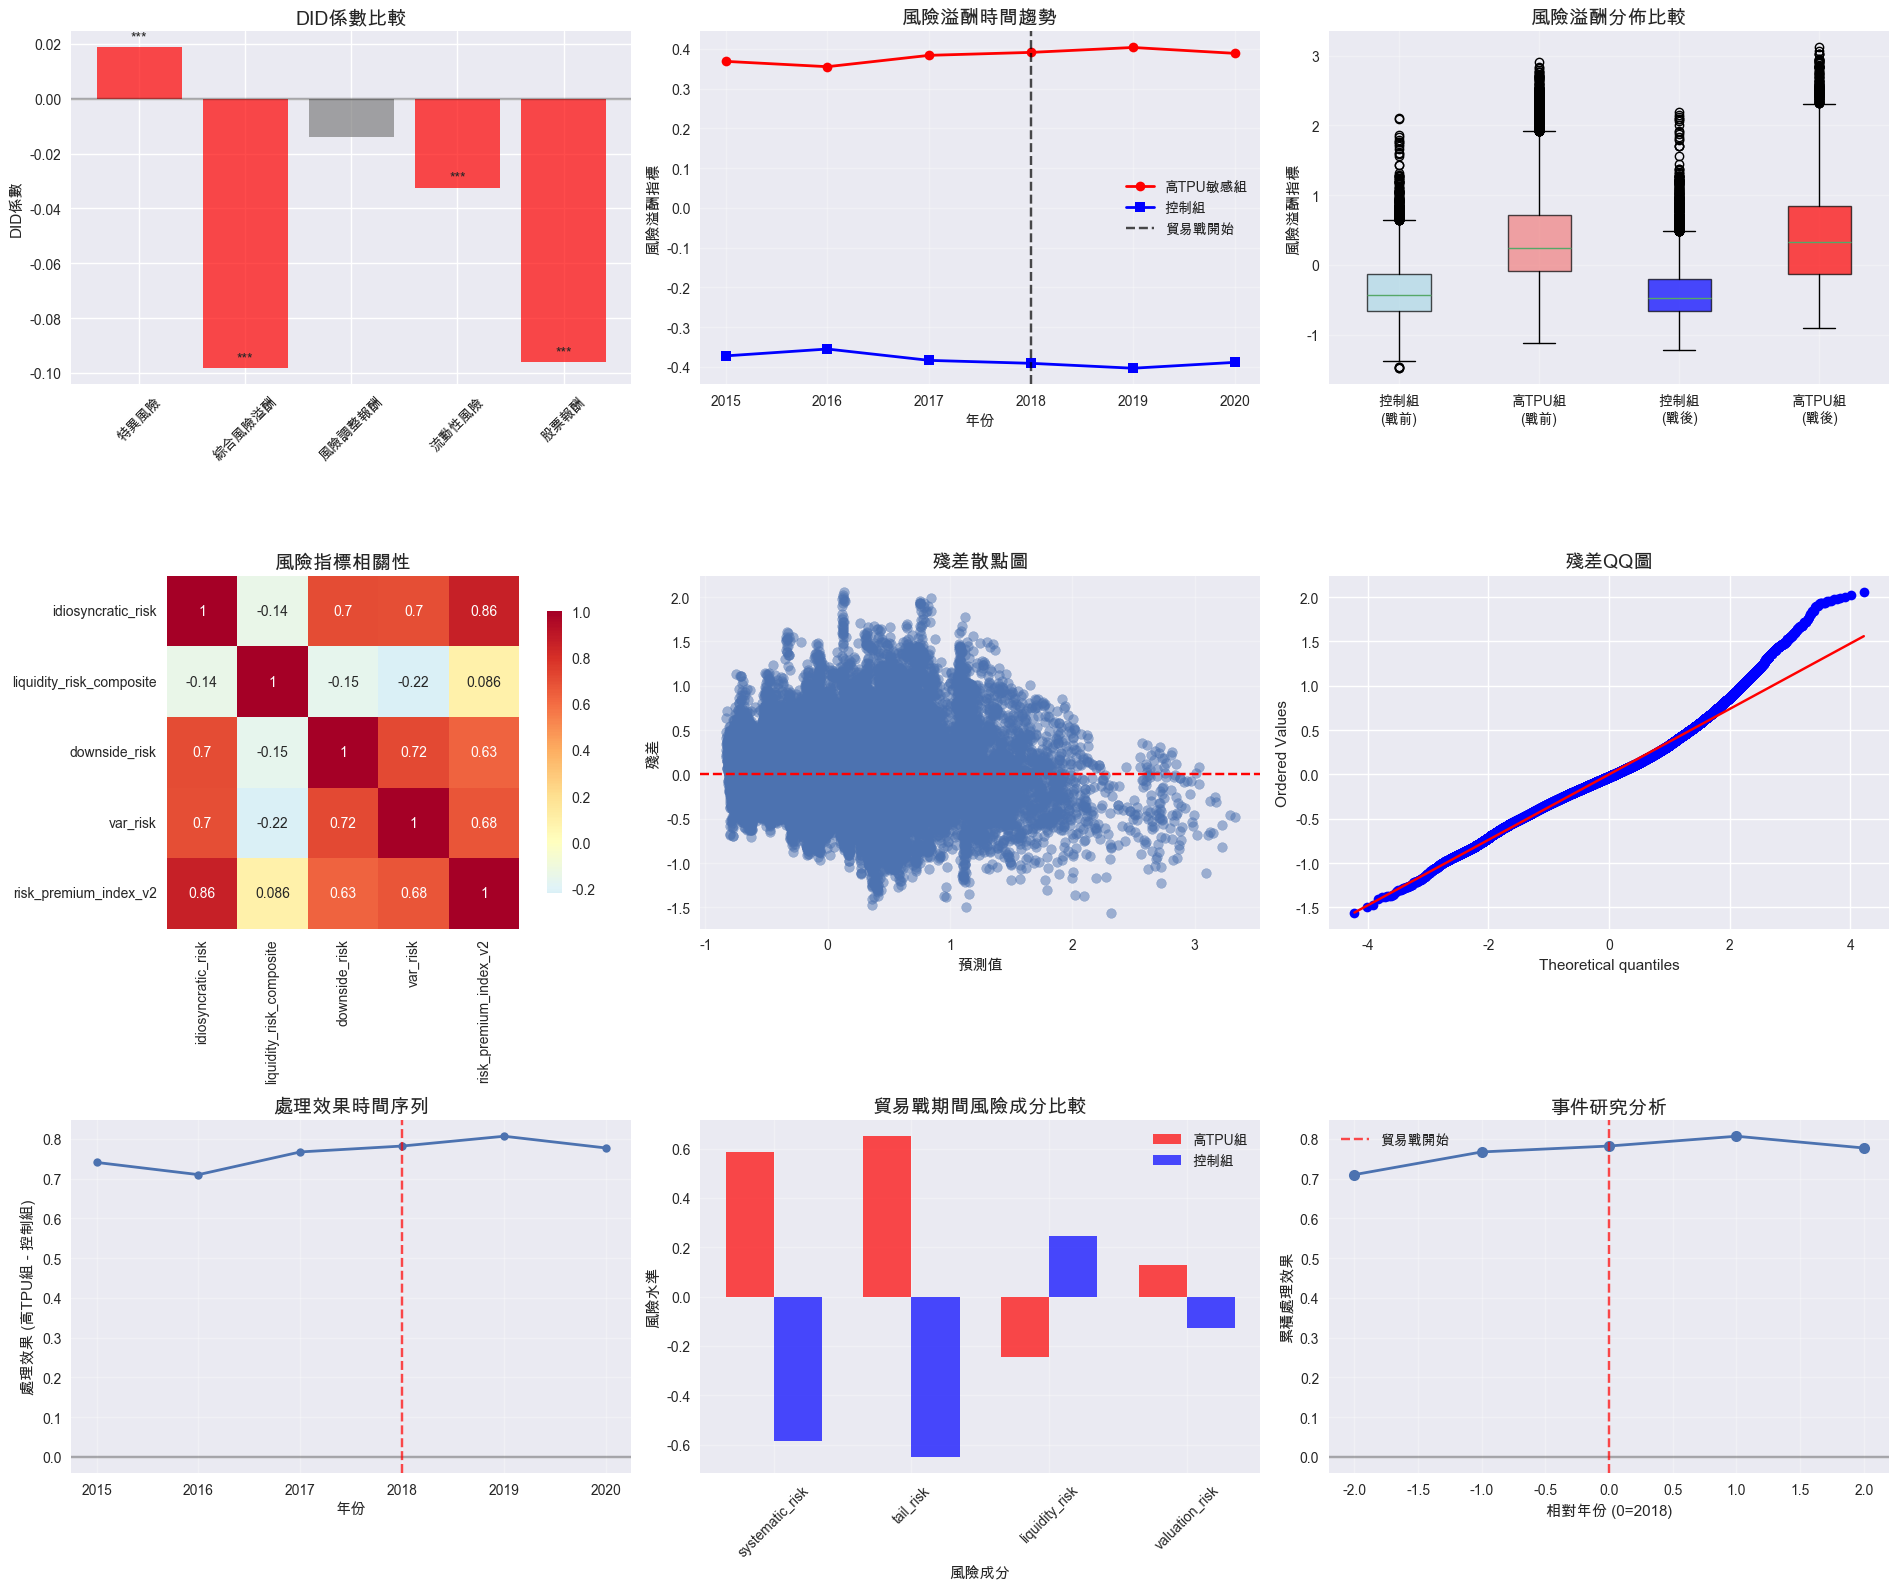

In [ ]:
# 創建視覺化圖表
from scipy import stats  
fig = create_comprehensive_visualizations(model_df, results_dict)




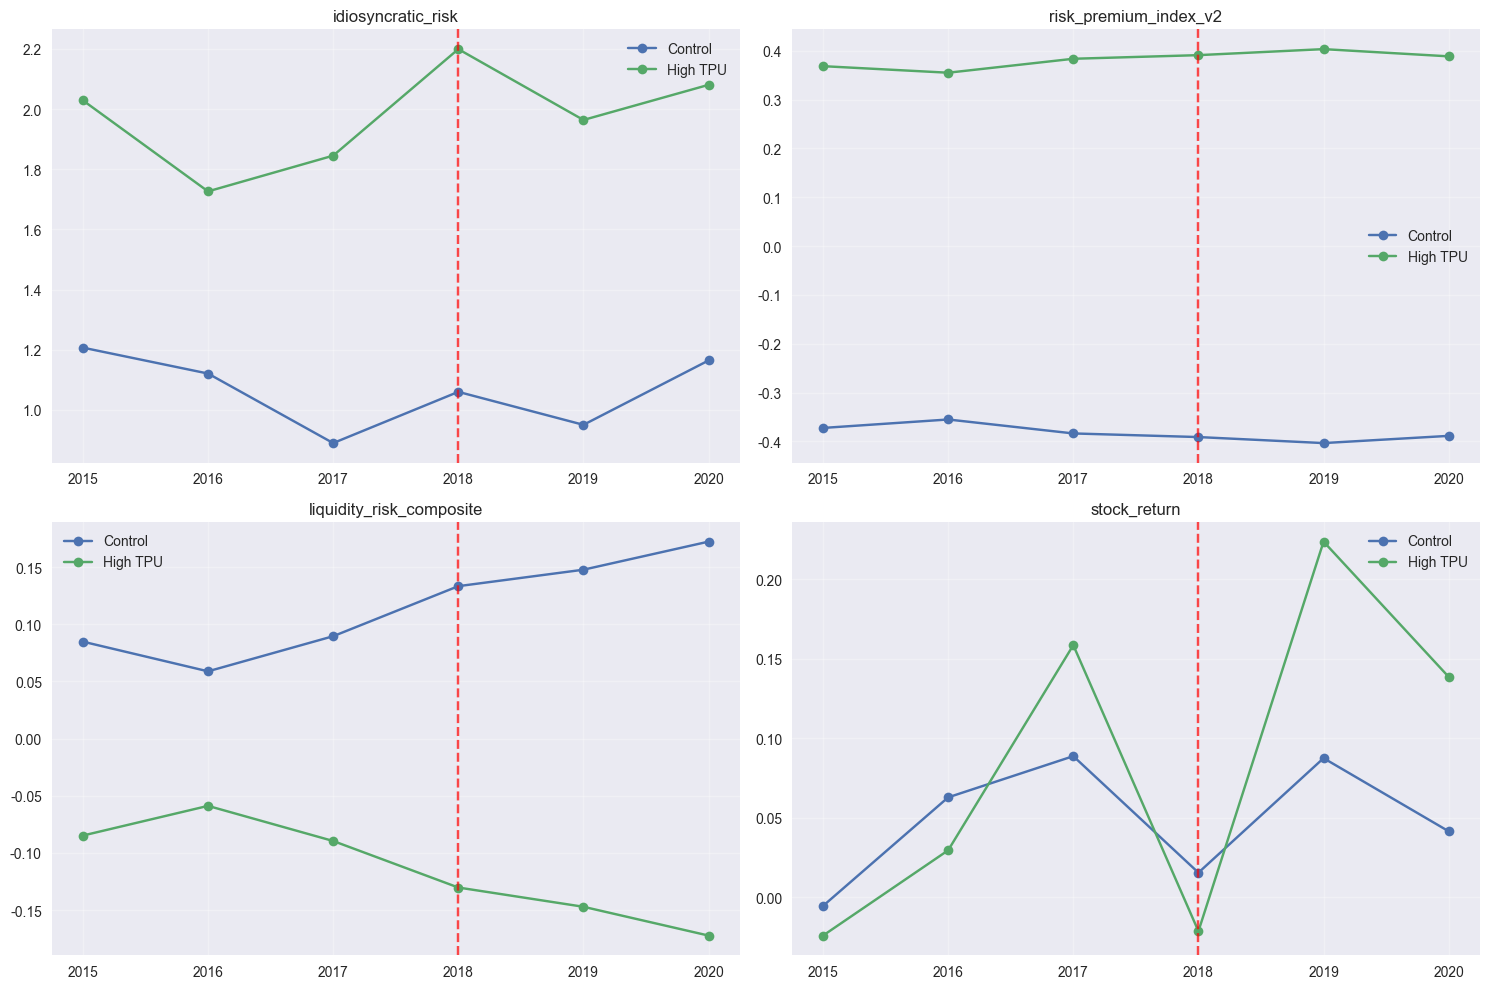

In [43]:
# 繪製各指標時間趨勢
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

indicators = ['idiosyncratic_risk', 'risk_premium_index_v2', 
              'liquidity_risk_composite', 'stock_return']

for i, indicator in enumerate(indicators):
    ax = axes[i//2, i%2]
    
    # 分組繪製
    for group in [0, 1]:
        data = model_df[model_df['HighTPU'] == group]
        trend = data.groupby('year')[indicator].mean()
        
        label = 'High TPU' if group == 1 else 'Control'
        ax.plot(trend.index, trend.values, marker='o', label=label)
    
    ax.axvline(x=2018, color='red', linestyle='--', alpha=0.7)
    ax.set_title(f'{indicator}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()